In [ ]:
# connet with your google drive
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os

In [3]:
!unzip -n /content/drive/MyDrive/175Project/state-farm-distracted-driver-detection.zip -x imgs/test/* -d 175Project

Streaming output truncated to the last 5000 lines.
  inflating: 175Project/imgs/train/c7/img_56636.jpg  
  inflating: 175Project/imgs/train/c7/img_56661.jpg  
  inflating: 175Project/imgs/train/c7/img_56699.jpg  
  inflating: 175Project/imgs/train/c7/img_56717.jpg  
  inflating: 175Project/imgs/train/c7/img_56724.jpg  
  inflating: 175Project/imgs/train/c7/img_56768.jpg  
  inflating: 175Project/imgs/train/c7/img_56779.jpg  
  inflating: 175Project/imgs/train/c7/img_56849.jpg  
  inflating: 175Project/imgs/train/c7/img_56899.jpg  
  inflating: 175Project/imgs/train/c7/img_56938.jpg  
  inflating: 175Project/imgs/train/c7/img_5706.jpg  
  inflating: 175Project/imgs/train/c7/img_57076.jpg  
  inflating: 175Project/imgs/train/c7/img_57122.jpg  
  inflating: 175Project/imgs/train/c7/img_57137.jpg  
  inflating: 175Project/imgs/train/c7/img_5715.jpg  
  inflating: 175Project/imgs/train/c7/img_57278.jpg  
  inflating: 175Project/imgs/train/c7/img_57321.jpg  
  inflating: 175Project/imgs/trai

In [5]:
os.chdir('175Project')

#TODO:
  * import data -- done!
  * create Resnet50
  * tune hyperparemeters
  * check performance

# Define customized DataSet

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, SequentialSampler, Dataset, random_split

from torchvision.transforms import ToTensor
import torchvision.transforms as T
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
import timeit

from PIL import Image

In [7]:
import os
import pandas as pd
from torchvision.io import read_image

In [8]:
project_path = '/content/175Project/' # google colab path
imgs_path = os.path.join(project_path, 'imgs') # imgs directory path
training_label_path = project_path + 'driver_imgs_list.csv' # annotaion file path

In [9]:
df = pd.read_csv(training_label_path)

In [10]:
df.subject.unique()

array(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024',
       'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049',
       'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072',
       'p075', 'p081'], dtype=object)

In [11]:
gpu_dtype = torch.cuda.FloatTensor

In [12]:
# csv header: subject, classname, img
class DriverImageDataset(Dataset):
  """
  Load training data set.
  Arguments:
    annotations_file: path to the csv file that contains the label of each images
    img_dir: directory contains traning images
            Structures:
            imgs/
              c0/
              c1/
              ...
              c9/
    transform: tranform the data type, usually use ToTensor() here
    target_transform: tranform the target data type
  """
  def __init__(self, annotations_file, img_dir, train=True, transform=None):
      self.df = pd.read_csv(annotations_file) # dataFrame
      self.img_dir = img_dir
      self.transform = transform

      # split the training data set into train and valid part 
      self.subjects = self.df['subject'].unique()
      self.train_df = self.df[self.df.subject.isin(self.subjects[:20])]
      self.valid_df = self.df[self.df.subject.isin(self.subjects[20:])]
      # random shuffle
      self.train_df = self.train_df.sample(frac=1, random_state=1)
      self.valid_df = self.valid_df.sample(frac=1, random_state=1)

      self.img_labels = self.train_df if train else self.valid_df

  def __len__(self):
      return len(self.img_labels)

  def __getitem__(self, idx):
      img_path = os.path.join(self.img_dir, 'train', self.img_labels.iloc[idx, 1], self.img_labels.iloc[idx, 2])
      image = Image.open(img_path) # read in image, shape is 3 * 480 * 640
      image = self.transform(image) # transform the image
      label = self.img_labels.iloc[idx, 1] # read the label, ex. c0, c1 ... c9
      label = torch.tensor(float(label[1:]))  # transform label to tensor
      return (image, label)

In [13]:
class testDataset(Dataset):
  def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        self.test_dir = os.path.join(self.img_dir, 'test')
        self.img_paths = [os.path.join(self.test_dir, i) for i in os.listdir(self.test_dir)]

  def __len__(self):
        return len(self.img_paths)

  def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path) 
        image = self.tranform(image)
        return image

# Load training data and split it into traning sets and validation sets, 0.75 : 0.25

In [14]:
train_set = DriverImageDataset(training_label_path, img_dir=imgs_path, train=True, transform=ToTensor())
validation_set = DriverImageDataset(training_label_path, img_dir=imgs_path, train=False, transform=ToTensor())

num_train = len(train_set)
num_valid = len(validation_set)
total_data = num_train + num_valid

In [15]:
print(f'Total: {total_data}')
print(f'Train data length: {len(train_set)}')
print(f'Validation data length: {len(validation_set)}')

Total: 22424
Train data length: 17778
Validation data length: 4646


In [16]:
loader_train = DataLoader(train_set, batch_size=32, num_workers=2)
loader_validation = DataLoader(validation_set, batch_size=32, num_workers=2)

# Label Map

In [17]:
label_map = {
    0: 'safe driving',
    1: 'texting - right',
    2: 'talking on the phone - right',
    3: 'texting - left',
    4: 'talking on the phone - left',
    5: 'operating the radio',
    6: 'drinking',
    7: 'reaching behind',
    8: 'hair and makeup',
    9: 'talking to passenger'
}

### Example of ploting a image

In [ ]:
def plot_img(img: torch.Tensor):
  plt.imshow(img.transpose(0,2).transpose(0,1))
  plt.show()

Label: 3.0


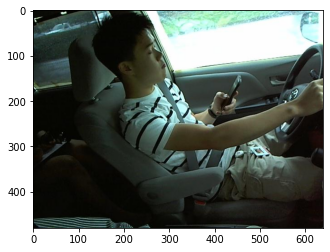

In [ ]:
path = 'imgs/train/c3/img_58188.jpg'
image = read_image(path)
print(f'Label: 3.0')
plot_img(image)

In [ ]:
x, y = next(iter(loader_train))

<class 'torch.Tensor'>
torch.Size([3, 480, 640])
torch.Size([3, 480, 640])


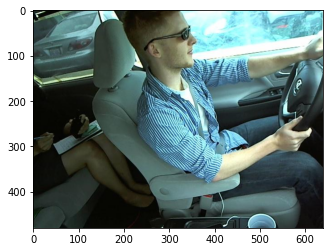

In [ ]:
sample_img_path = 'imgs/train/c0/img_100026.jpg'
img = read_image(sample_img_path) #3  * 480 * 640 -> 480 * 640 *3
print(type(img))
print(img.shape)
print(img.shape)
plot_img(img)

In [18]:
def train(model, loader, loss_fn, optimizer, num_epochs = 1, print_every = 100):
    for epoch in range(num_epochs):
      print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
      model.train()
      for t, (x, y) in enumerate(loader):
          x_var = Variable(x.type(gpu_dtype))
          y_var = Variable(y.type(gpu_dtype).long())
          scores = model(x_var)
          
          loss = loss_fn(scores, y_var)
          if (t + 1) % print_every == 0:
              print('t = %d, loss = %.4f' % (t + 1, loss.item()))

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()


def check_accuracy(model, loader):  
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        with torch.no_grad():
            x_var = Variable(x.type(gpu_dtype))

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

# Example model

In [ ]:

class BCM(nn.Module):
  """
  Use the architecture:
  (Batch normalization -> Convolution -> MaxPooling) * 3 -> 
  """
  def __init__(self, num_class=10):
    super(BCM, self).__init__()

    # 3 * 480 * 640
    self.layer1 = nn.Sequential(
        nn.BatchNorm2d(3),
        nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # 3 * 240 * 320
    self.layer2 = nn.Sequential(
        nn.BatchNorm2d(3),
        nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # 3 * 120 * 160
    self.layer3 = nn.Sequential(
        nn.BatchNorm2d(3),
        nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # 3 * 60 * 80
    self.layer4 = nn.Sequential(
        nn.BatchNorm2d(3),
        nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # 3 * 30 * 40
    self.layer5 = nn.Sequential(
        nn.Linear(3* 30 * 40, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, num_class)
    )
    # 10

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = out.reshape(out.size(0), -1)
    out = self.layer5(out)
    return out

In [ ]:
# input shape 3*480*640
model = BCM()
model = model.type(gpu_dtype)
loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=1e-3)

In [ ]:
%%time
train(model, loader_train, loss_fn, optimizer, num_epochs=5, print_every=100)

Starting epoch 1 / 5
t = 100, loss = 1.8013
t = 200, loss = 0.8177
t = 300, loss = 0.2145
t = 400, loss = 0.1387
t = 500, loss = 0.1384
Starting epoch 2 / 5
t = 100, loss = 0.2326
t = 200, loss = 0.0504
t = 300, loss = 0.0892
t = 400, loss = 0.0785
t = 500, loss = 0.0104
Starting epoch 3 / 5
t = 100, loss = 0.0042
t = 200, loss = 0.0200
t = 300, loss = 0.0284
t = 400, loss = 0.0589
t = 500, loss = 0.0076
Starting epoch 4 / 5
t = 100, loss = 0.0029
t = 200, loss = 0.0841
t = 300, loss = 0.3651
t = 400, loss = 0.0070
t = 500, loss = 0.0020
Starting epoch 5 / 5
t = 100, loss = 0.0058
t = 200, loss = 0.0084
t = 300, loss = 0.0122
t = 400, loss = 0.0737
t = 500, loss = 0.0987
CPU times: user 3min, sys: 21.8 s, total: 3min 22s
Wall time: 5min 27s


In [ ]:
%%time 
print("Training accuracy:")
check_accuracy(model, loader_train)

Training accuracy:
Got 17692 / 17778 correct (99.52)
CPU times: user 36.5 s, sys: 4.36 s, total: 40.9 s
Wall time: 1min 6s


In [ ]:
%%time 
print("Validation accuracy:")
check_accuracy(model, loader_validation)

Validation accuracy:
Got 708 / 4646 correct (15.24)
CPU times: user 9.59 s, sys: 1.27 s, total: 10.9 s
Wall time: 17.4 s


# ResNet50 Model

In [37]:
# reset paramenters of a model
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [41]:
num_class = 10
model = models.resnet50()
outLayer = nn.Linear(model.fc.in_features, num_class)

model.fc = outLayer # change to output class to 10
model = model.type(gpu_dtype)
loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = optim.RMSprop(model.parameters(), lr=5e-4, weight_decay=1e-6)

In [20]:
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

In [21]:
train_set = DriverImageDataset(training_label_path, img_dir=imgs_path, train=True, transform=transform)
validation_set = DriverImageDataset(training_label_path, img_dir=imgs_path, train=False, transform=transform)

num_train = len(train_set)
num_valid = len(validation_set)
total_data = num_train + num_valid

In [22]:
loader_train = DataLoader(train_set, batch_size=20, num_workers=2)
loader_validation = DataLoader(validation_set, batch_size=20, num_workers=2)

In [ ]:
learning_rates = [5e-4, 1e-4, 1e-3]
weight_decays = [5e-5, 1e-5, 5e-6, 1e-6, 5e-7, 1e-7]
for lr in learning_rates:
  for wd in weight_decays:
    print(f"learning rate: {lr}")
    print(f"weigth decay: {wd}")
    model.apply(weight_reset)
    optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=wd)
    train(model, loader_train, loss_fn, optimizer, num_epochs=1, print_every=100)
    check_accuracy(model, loader_validation)

learning rate: 0.0005
weigth decay: 5e-05
Starting epoch 1 / 1
t = 100, loss = 1.9573
t = 200, loss = 1.8057
t = 300, loss = 1.6339
t = 400, loss = 1.0886
t = 500, loss = 0.9251
t = 600, loss = 0.2605
t = 700, loss = 0.3887
t = 800, loss = 0.2508
Got 1482 / 4646 correct (31.90)
learning rate: 0.0005
weigth decay: 1e-05
Starting epoch 1 / 1
t = 100, loss = 1.9325
t = 200, loss = 1.8317
t = 300, loss = 1.1499
t = 400, loss = 1.2954
t = 500, loss = 0.7209
t = 600, loss = 0.4992
t = 700, loss = 1.6310
t = 800, loss = 0.9674
Got 1339 / 4646 correct (28.82)
learning rate: 0.0005
weigth decay: 5e-06
Starting epoch 1 / 1
t = 100, loss = 1.9581
t = 200, loss = 1.7018
t = 300, loss = 1.4131
t = 400, loss = 1.0047
t = 500, loss = 1.1180
t = 600, loss = 0.2921
t = 700, loss = 0.5052


In [40]:
%%time
train(model, loader_train, loss_fn, optimizer, num_epochs=1, print_every=100)
print("Validation accuracy:")
check_accuracy(model, loader_validation)

Starting epoch 1 / 1
t = 100, loss = 2.2251
t = 200, loss = 2.2442
t = 300, loss = 2.3782


KeyboardInterrupt: ignored

In [ ]:
%%time 
print("Training accuracy:")
check_accuracy(model, loader_train)

Training accuracy:
Got 16702 / 17778 correct (93.95)
CPU times: user 22 s, sys: 2.64 s, total: 24.6 s
Wall time: 2min


In [33]:
%%time 
print("Validation accuracy:")
check_accuracy(model, loader_validation)

Validation accuracy:
Got 1605 / 4646 correct (34.55)
CPU times: user 9.2 s, sys: 768 ms, total: 9.96 s
Wall time: 32.8 s
